# **<center>外卖订单评价检验</center>**
## **<center>文本情感分析</center>**


<h4 style="text-align:right">陈珺琨 2021200142</h4>

## 一、导入基本库与数据集

### 1.1 导入基本库

In [91]:
# 导入需要的数据包
import pandas as pd
import numpy as np
import patchworklib as pw
import threadpoolctl
import matplotlib.pyplot as plt
from datetime import datetime 
import random
import seaborn as sns
import os
os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"

import warnings
warnings.filterwarnings("ignore")

<Figure size 100x100 with 0 Axes>

### 1.2 加载Bert模型

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# 加载预训练的BERT tokenizer
model = AutoModelForSequenceClassification.from_pretrained('google-bert/bert-base-chinese', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### 1.3 载入数据集

In [3]:
from datasets import load_dataset

# 加载美团外卖数据集
dataset = load_dataset('XiangPan/waimai_10k')


Repo card metadata block was not found. Setting CardData to empty.


## 二、Stage1-订单评价情感分析

### 2.1 训练Bert模型

In [5]:
import numpy as np
from datasets import load_dataset
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, predictions)}

def predict(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt")

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits).item()

    return int(predicted_class)
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-chinese")

Repo card metadata block was not found. Setting CardData to empty.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.318600,0.371693,0.890945


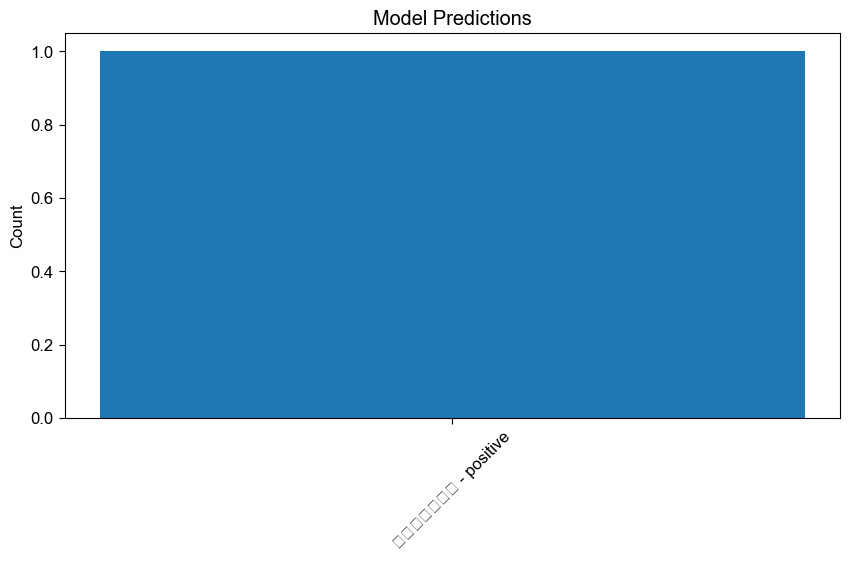

In [4]:
# 训练Bert模型

CLASS_NAME = {0: "negative", 1: "positive"}

dataset = load_dataset("XiangPan/waimai_10k")

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# 将数据集划分为训练集和验证集
datasets_all = tokenized_datasets["train"].shuffle(seed=42)
train_dataset = datasets_all.select(range(9000))
eval_dataset = datasets_all.select(range(9001,11987))

model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-chinese", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    num_train_epochs=1,
    logging_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    report_to="none",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

# 测试模型
test_reviews = [
    "菜品非常丰富。"
]

model.to('cpu')
text_list = []
for review in test_reviews:
    label = predict(review, model, tokenizer)
    text_list.append(review + " - " + CLASS_NAME[label])

# 使用 Matplotlib 展示结果
import matplotlib.pyplot as plt

labels = [CLASS_NAME[label] for _ in test_reviews]
plt.figure(figsize=(10, 5))
plt.bar(range(len(test_reviews)), [1]*len(test_reviews), tick_label=text_list)
plt.xticks(rotation=45)
plt.title("Model Predictions")
plt.ylabel("Count")
plt.show()


In [14]:
# 测试模型
test_reviews = [
    "菜品非常丰富，每道菜都非常美味可口。特别是他们家的宫保鸡丁，味道真的很棒，鸡肉鲜嫩多汁，酱汁调味适中。每次点餐都能有新的惊喜，感觉每一道菜都经过精心烹饪。送餐速度也很快，菜到的时候还是热乎乎的，真的很满意。",
    "这家外卖不仅菜品味道好，包装也非常精美。每次收到外卖都感觉像是收到了礼物一样，包装盒干净整洁，里面还附赠了餐巾纸和湿巾，特别贴心。配送员的态度也很好，总是面带微笑，送餐速度也很快。总之，是一次非常愉快的用餐体验。",
    "我对这家外卖印象非常深刻，因为他们家的菜品不仅美味，而且非常健康。每道菜都使用新鲜的食材，吃起来非常放心。特别喜欢他们家的沙拉，蔬菜非常新鲜，调料也很特别。每次点餐都能感受到店家的用心，是我目前最喜欢的一家外卖店。",
    "非常正宗，让我有一种回到家乡的感觉。特别是他们家的麻婆豆腐，味道特别地道，辣得很过瘾。价格也非常实惠，分量足够，一份就能吃饱。每次点餐都觉得物超所值，非常推荐！",
    "配送速度真的是超乎想象，每次点餐从下单到送达都不会超过30分钟。菜品的味道也一如既往的好，特别喜欢他们家的红烧牛肉，肉质酥烂入味，搭配的土豆也煮得刚刚好。每次点餐都很期待，绝对值得一试。",
    
    "配送速度实在是太慢了，我下单之后足足等了一个小时才送到。收到的时候，菜已经凉了，味道也大打折扣。特别是炸鸡块，完全没有了刚炸出来的香脆口感，感觉很失望。希望能改进配送速度，否则不太敢再点。",
    "菜品味道一般，而且份量也不足。点了一份宫保鸡丁，结果鸡肉少得可怜，基本都是青椒和花生，吃起来非常失望。价格也不算便宜，总感觉物不所值。希望店家能改进菜品的份量和质量。",
    "简陋，收到的时候盒子已经变形，汤汁也洒了出来。配送员的态度也很冷淡，完全没有服务意识。菜品的味道也不怎么样，感觉就像是随便炒出来的，没有一点特色。这样的用餐体验真的很糟糕。",
    "每一道菜都非常油腻，吃起来很不舒服。特别是他们家的红烧肉，油腻得让人无法下咽，完全没有食欲。配送速度也很慢，收到的时候菜已经冷了。希望店家能改进菜品质量，否则真的不会再点了。",
    "这家外卖的价格实在是太高了，性价比很低。点了一份麻婆豆腐，味道很一般，完全不值这个价钱。而且份量也很少，根本吃不饱。配送速度也不快，整体用餐体验非常差。希望店家能调整价格，提升菜品质量。",
    "女朋友和别人在酒店，让我给她点外卖。里面居然有生黄瓜，为什么会有生的黄瓜，我女朋友最讨厌吃了。现在要闹着和我分手，怎么办。我受不了了。为什么要放黄瓜，如果放黄瓜话，她就不会和我分手了……",
    "直接差评吸管为什么不是90个，小心我老大坠机，直接向你无限肘击",
    "备注都不看的吗，说了要另带小米辣和辣椒面醋",
    "这个土豆粉我知道，上次我们村闹洪灾就是这个土豆粉把水吸完的"
]


model.to('cpu')
text_list = []
for review in test_reviews:
    label = predict(review, model, tokenizer)
    text_list.append([review, CLASS_NAME[label]])  # 将review和类别名称作为一个列表添加

# 创建DataFrame，指定列名
result = pd.DataFrame(text_list, columns=['Review', 'Class'])

# 显示DataFrame
result

,Review,Class
0,菜品非常丰富，每道菜都非常美味可口。特别是他们家的宫保鸡丁，味道真的很棒，鸡肉鲜嫩多汁，酱汁...,positive
1,这家外卖不仅菜品味道好，包装也非常精美。每次收到外卖都感觉像是收到了礼物一样，包装盒干净整洁...,positive
2,我对这家外卖印象非常深刻，因为他们家的菜品不仅美味，而且非常健康。每道菜都使用新鲜的食材，吃...,positive
3,非常正宗，让我有一种回到家乡的感觉。特别是他们家的麻婆豆腐，味道特别地道，辣得很过瘾。价格也...,positive
4,配送速度真的是超乎想象，每次点餐从下单到送达都不会超过30分钟。菜品的味道也一如既往的好，特...,positive
5,配送速度实在是太慢了，我下单之后足足等了一个小时才送到。收到的时候，菜已经凉了，味道也大打折...,negative
6,菜品味道一般，而且份量也不足。点了一份宫保鸡丁，结果鸡肉少得可怜，基本都是青椒和花生，吃起来...,negative
7,简陋，收到的时候盒子已经变形，汤汁也洒了出来。配送员的态度也很冷淡，完全没有服务意识。菜品的...,negative
8,每一道菜都非常油腻，吃起来很不舒服。特别是他们家的红烧肉，油腻得让人无法下咽，完全没有食欲。...,negative
9,这家外卖的价格实在是太高了，性价比很低。点了一份麻婆豆腐，味道很一般，完全不值这个价钱。而且...,negative


### 2.2 保存原数据集BERT向量

In [76]:
from transformers import BertTokenizer, BertModel
from transformers import DistilBertModel, DistilBertTokenizer
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("waimai.csv")

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-chinese")

model = BertModel.from_pretrained("google-bert/bert-base-chinese", num_labels=2)

# 将模型设置为评估模式
model.eval()

# 获取 BERT 的文本嵌入
def get_bert_embeddings(texts):
    embeddings = []
    cnt = 0
    for text in texts:
        cnt += 1
        if cnt % 500 == 0:
            print("Process ", cnt, " texts.")

        inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=512)
        with torch.no_grad():
            outputs = model(**inputs)

        cls_embedding = outputs.last_hidden_state[0, 0, :].numpy()
        embeddings.append(cls_embedding)
    
    return embeddings

embeddings = get_bert_embeddings(df.iloc[:,1].tolist())
embeddings_df = pd.DataFrame(embeddings)

embeddings_df.columns = [f'problemEB_{i}' for i in range(embeddings_df.shape[1])]

# 查看 DataFrame
print(embeddings_df.head())

embeddings_df.to_csv("bert_emb.csv",index=False)

Process  500  texts.
Process  1000  texts.
Process  1500  texts.
Process  2000  texts.
Process  2500  texts.
Process  3000  texts.
Process  3500  texts.
Process  4000  texts.
Process  4500  texts.
Process  5000  texts.
Process  5500  texts.
Process  6000  texts.
Process  6500  texts.
Process  7000  texts.
Process  7500  texts.
Process  8000  texts.
Process  8500  texts.
Process  9000  texts.
Process  9500  texts.
Process  10000  texts.
Process  10500  texts.
Process  11000  texts.
Process  11500  texts.
   problemEB_0  problemEB_1  problemEB_2  problemEB_3  problemEB_4  \
0     0.002786     0.350907    -0.590879     0.624839     0.275236   
1    -0.388467     0.344315     0.032715    -0.823201     0.978599   
2     0.239318     0.292602     0.541065    -0.180603     0.326330   
3     0.463375     0.265843    -0.954373    -0.184800     0.771330   
4     0.536140     0.671927     0.256286     0.845530     0.309015   

   problemEB_5  problemEB_6  problemEB_7  problemEB_8  problemEB_9  ..

## 三、Stage2-订单评价讽刺分析

In [4]:
# 读取txt文件
def read_txt_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = [_.strip() for _ in f.readlines()]

    labels, texts = [], []
    for line in content:
        parts = line.split()
        #print(parts)
        label, text = parts[0], ''.join(parts[1:])
        labels.append(label)
        texts.append(text)

    return labels, texts


file_path = 'Chinese-S/data/train.txt'
labels, texts = read_txt_file(file_path)
s_train_df = pd.DataFrame({'label': labels, 'text': texts})

file_path = 'Chinese-S/data/test.txt'
labels, texts = read_txt_file(file_path)
s_test_df = pd.DataFrame({'label': labels, 'text': texts})

print(s_train_df.head())
print(s_test_df.head())

s_train_df['text_len'] = s_train_df['text'].apply(lambda x: len(x))
print(s_train_df.describe())


  label                                               text
0     0  这是最受气包的一届总统特朗普：我被陷害，我被诬告，我冤枉！特朗普反对者：我们只是在行使民主自...
1     0                        那些相信经济全球化会走向命运共同体的人现在天天被打脸。
2     0                                     嗯，这很西方，有强盗思维逻辑
3     0  试错的成本应该资本家承担，而不是消费者，别偷换概念。你试了，发现错了，就要及时召回，该换的换...
4     0                    呵呵呵呵，站着说话不腰疼，棚户区改造你们怎么不说，穷人不是人？
  label                     text
0     0             三文鱼：“你说谁呢？！”
1     0  来，看我打开直播，给出致命一击！呀呀呀，跳劈！
2     0             英国皇室应该可以出面了。
3     0            谷歌搜索不是抄袭雅虎的吗？
4     0        要是忍了又没发展出来那不骂得更惨？
          text_len
count  2119.000000
mean     23.719679
std      17.966992
min       1.000000
25%      11.500000
50%      19.000000
75%      30.000000
max     116.000000


### 3.1 多特征讽刺识别

根据两篇基于单语句讽刺检测的论文，它们给出了一系列针对讽刺识别的特征，例如**情感极性**，**基于句法、基于模式的特征向量**。本点针对这两种方案进行操作。

1. **情感极性**：Recognition of Sarcasm in Tweets Based on Concept Level Sentiment Analysis and Supervised Learning Approaches(Piyoros Tungthamthiti, 2014)；

2. **基于句法、基于模式的特征向量**：Enhanced Sentiment Learning Using Twitter Hashtags and Smileys(Dmitry Davidov, Oren Tsur, 2010)

#### 3.1.1 情感极性分析

原文基于英文语料，采用SentiStrength和SenticNet词典进行词汇的情感分析；在中文语料情境下，尝试使用SnowNLP模型、或更换为cnsenti情感词典进行分析。

In [7]:
# 讽刺语句数据集
s_train_df

,label,text,text_len
0,0,这是最受气包的一届总统特朗普：我被陷害，我被诬告，我冤枉！特朗普反对者：我们只是在行使民主自...,52
1,0,那些相信经济全球化会走向命运共同体的人现在天天被打脸。,27
2,0,嗯，这很西方，有强盗思维逻辑,14
3,0,试错的成本应该资本家承担，而不是消费者，别偷换概念。你试了，发现错了，就要及时召回，该换的换...,93
4,0,呵呵呵呵，站着说话不腰疼，棚户区改造你们怎么不说，穷人不是人？,31
...,...,...,...
2114,0,就是英国人自己拍的电视机，可以搜下，拍的很不错，相当有讽刺风格,31
2115,0,宣战！,3
2116,0,卡钦斯基是图,6
2117,0,国会姥爷：又想从我这骗钱，地主家也没有余粮了啊,23


##### 3.1.1.1 SnowNLP

In [38]:
# 数据预处理和特征工程
def calculate_word_sentiment_scores(text):
    s = SnowNLP(text)  # 创建SnowNLP对象
    words = s.words  # 使用SnowNLP的分词功能
    sum_pos_score = 0
    sum_neg_score = 0
    for word in words:
        word_sn = SnowNLP(word)
        # 计算正面和负面分数
        if word_sn.sentiments > 0.5:
            sum_pos_score += 1
        elif word_sn.sentiments < 0.5:  # 注意这里的条件应该是小于0.5，因为sentiments属性不会返回负值
            sum_neg_score += 1
    return sum_pos_score, sum_neg_score

# 应用到数据集
s_train_df['sum_pos_score'], s_train_df['sum_neg_score'] = zip(*s_train_df['text'].apply(calculate_word_sentiment_scores))

# 特征选择
X = s_train_df[['text_len', 'sum_pos_score', 'sum_neg_score']]
y = s_train_df['label']

In [24]:
s_train_df['text']

0       这是最受气包的一届总统特朗普：我被陷害，我被诬告，我冤枉！特朗普反对者：我们只是在行使民主自...
1                             那些相信经济全球化会走向命运共同体的人现在天天被打脸。
2                                          嗯，这很西方，有强盗思维逻辑
3       试错的成本应该资本家承担，而不是消费者，别偷换概念。你试了，发现错了，就要及时召回，该换的换...
4                         呵呵呵呵，站着说话不腰疼，棚户区改造你们怎么不说，穷人不是人？
                              ...                        
2114                      就是英国人自己拍的电视机，可以搜下，拍的很不错，相当有讽刺风格
2115                                                  宣战！
2116                                               卡钦斯基是图
2117                              国会姥爷：又想从我这骗钱，地主家也没有余粮了啊
2118                                      太少了，十天才一次，表示不过瘾
Name: text, Length: 2119, dtype: object

In [31]:
words = SnowNLP("真山真水拍成假山假水，这导演太厉害了。").words
words

['真山', '真', '水', '拍', '成假', '山假', '水', '，', '这', '导演', '太', '厉害', '了', '。']

In [32]:
for word in words:
    word_sn = SnowNLP(word)
    # 计算正面和负面分数
    if word_sn.sentiments > 0.5:
        print(word,word_sn.sentiments)
    elif word_sn.sentiments < 0.5:  # 注意这里的条件应该是小于0.5，因为sentiments属性不会返回负值
        print(word,word_sn.sentiments)

真山 0.5744488213563617
真 0.5305096913137115
水 0.33777777777777795
拍 0.4782608695652175
水 0.33777777777777795
， 0.5262327818078083
这 0.5262327818078083
导演 0.7199999999999998
太 0.34387502381406
厉害 0.35964912280701733
了 0.5262327818078083
。 0.5262327818078083


In [37]:
# 遍历分词结果和词性标注
for word, flag in SnowNLP("真山真水拍成假山假水，这导演太厉害了。").tags:
    if flag == 'a' or flag == 'd':  # 筛选形容词和副词
        word_sn = SnowNLP(word)
        # 计算正面和负面分数
        if word_sn.sentiments > 0.5:
            print(word,word_sn.sentiments)
        elif word_sn.sentiments < 0.5:
            print(word,word_sn.sentiments)

太 0.34387502381406
厉害 0.35964912280701733


SnowNLP主要对语段、句子做情感分析，对独立词汇的分析效果较差。

##### 3.1.1.2 中文情感分析库CnSenti

In [45]:
from cnsenti import Sentiment

senti = Sentiment()
test_text= '今天真是我的幸运日，不仅车子被堵在路上动弹不得，还意外地享受了一顿昂贵的罚单早餐，我简直‘爱’极了这样的惊喜！'
result = senti.sentiment_count(test_text)
print(result)

{'words': 36, 'sentences': 1, 'pos': 3, 'neg': 2}


上述语句具有3个正面情绪词汇、2个负面情绪词汇，很有可能是讽刺语句。

In [57]:
# 数据预处理和特征工程
def calculate_sentiment_scores(text):
    result = senti.sentiment_count(text)  # 使用cnsenti进行情感分析
    sum_pos_score = result['pos']
    sum_neg_score = result['neg']
    return sum_pos_score, sum_neg_score

# 应用到数据集
s_train_df['sum_pos_score'], s_train_df['sum_neg_score'] = zip(*s_train_df['text'].apply(calculate_sentiment_scores))
# 判断极性
s_train_df['polarity'] = s_train_df.apply(lambda row: 1 if row['sum_pos_score'] != 0 and row['sum_neg_score'] != 0 else 0, axis=1).astype(int)

# 特征选择
X = s_train_df[['text', 'sum_pos_score', 'sum_neg_score', 'polarity']]
y = s_train_df['label']

In [64]:
# 测量拟合效果
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
print("Accuracy score: {}".format(accuracy_score(s_train_df['polarity'], s_train_df['label'].astype(int))))
print(classification_report(s_train_df['polarity'], s_train_df['label'].astype(int)))

Accuracy score: 0.7418593676262388
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1765
           1       0.25      0.27      0.26       354

    accuracy                           0.74      2119
   macro avg       0.55      0.55      0.55      2119
weighted avg       0.75      0.74      0.75      2119



#### 3.1.2 语句特征向量（基于句法）

原论文“基于模式”的方法针对英语效果较好，而中文效果较差；此处仅基于句法制造特征向量。

In [83]:
s_train_df.drop(['sentence_length','num_question','num_quotes','num_exclamation'], axis=1, inplace=True)

In [84]:
import pandas as pd
import re
from collections import Counter

# 基于句法的特征向量
def punctuation_features(text):
    features = {
        'num_exclamation': len(re.findall(r'！', text)),
        'num_question': len(re.findall(r'？', text)),
        'num_quotes': len(re.findall(r'“', text))
    }
    return features

# 应用特征提取函数
s_train_df['punctuation_features'] = s_train_df['text'].apply(punctuation_features)

# 展开特征
s_train_df = s_train_df.join(s_train_df['punctuation_features'].apply(pd.Series))

# 删除原始的特征列
s_train_df.drop(['punctuation_features'], axis=1, inplace=True)

# 查看结果
s_train_df

,label,text,text_len,sum_pos_score,sum_neg_score,polarity,num_exclamation,num_question,num_quotes
0,0,这是最受气包的一届总统特朗普：我被陷害，我被诬告，我冤枉！特朗普反对者：我们只是在行使民主自...,52,0,2,0,3,0,0
1,0,那些相信经济全球化会走向命运共同体的人现在天天被打脸。,27,1,0,0,0,0,0
2,0,嗯，这很西方，有强盗思维逻辑,14,1,1,1,0,0,0
3,0,试错的成本应该资本家承担，而不是消费者，别偷换概念。你试了，发现错了，就要及时召回，该换的换...,93,2,2,1,0,0,0
4,0,呵呵呵呵，站着说话不腰疼，棚户区改造你们怎么不说，穷人不是人？,31,0,2,0,0,1,0
...,...,...,...,...,...,...,...,...,...
2114,0,就是英国人自己拍的电视机，可以搜下，拍的很不错，相当有讽刺风格,31,0,1,0,0,0,0
2115,0,宣战！,3,0,0,0,1,0,0
2116,0,卡钦斯基是图,6,0,0,0,0,0,0
2117,0,国会姥爷：又想从我这骗钱，地主家也没有余粮了啊,23,0,1,0,0,0,0


##### 训练KNN模型

In [100]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

# 应用特征提取函数
s_train_df['features'] = s_train_df['text'].apply(punctuation_features)

# 将特征转换为DataFrame
features_df = s_train_df['features'].apply(pd.Series)

# 特征选择
X = features_df
y = s_train_df['label']

# 数据预处理
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 模型训练
knn = KNeighborsClassifier(n_neighbors=4)
knn.fit(X_train, y_train)

# 模型评估
predictions = knn.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

Accuracy score: 0.7924528301886793
              precision    recall  f1-score   support

           0       0.80      0.98      0.88       338
           1       0.40      0.05      0.08        86

    accuracy                           0.79       424
   macro avg       0.60      0.51      0.48       424
weighted avg       0.72      0.79      0.72       424



##### 训练random forests模型

多训练一种模型，用于判断是数据集-方法不适配，还是模型选取有问题。

In [103]:
# 建构随机森林模型
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=420, random_state=111)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=420, random_state=111)

In [104]:
# 模型评估
predictions = rf.predict(X_test)
print("Accuracy score: {}".format(accuracy_score(y_test, predictions)))
print(classification_report(y_test, predictions))

Accuracy score: 0.7877358490566038
              precision    recall  f1-score   support

           0       0.80      0.99      0.88       338
           1       0.00      0.00      0.00        86

    accuracy                           0.79       424
   macro avg       0.40      0.49      0.44       424
weighted avg       0.63      0.79      0.70       424



利用语句特征向量对该数据集不适用。

### 3.2 利用讽刺分析数据集训练深度学习网络

#### 3.2.1 利用Bert向量初步训练

##### 文本转换为embeddings

In [5]:
import os
# 使用GPU训练
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7,8"

import numpy as np
from keras.utils import to_categorical
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import Input, BatchNormalization, Dense
import torch
from transformers import AutoTokenizer, AutoModel

# 初始化tokenizer和model
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-chinese")
model = AutoModel.from_pretrained("google-bert/bert-base-chinese")

# 读取文件并进行转换
def encode_text(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    # 使用最后一层的hidden states的平均值作为句子的表示
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings

print('begin encoding')
train_embeddings = encode_text(s_train_df['text'].tolist())
test_embeddings = encode_text(s_test_df['text'].tolist())
print('end encoding')

begin encoding
end encoding


##### 训练模型

In [203]:
x_train = np.array(train_embeddings)
x_test = np.array(test_embeddings)
y_train = np.array(s_train_df['label'].values)
y_test = np.array(s_test_df['label'].values)
print('x_train: ', x_train.shape)

# Convert class vectors to binary class matrices.
num_classes = 2
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# 创建模型
x_in = Input(shape=(768,))
x_out = Dense(32, activation="relu")(x_in)
x_out = BatchNormalization()(x_out)
x_out = Dense(num_classes, activation="softmax")(x_out)
model = Model(inputs=x_in, outputs=x_out)
print(model.summary())

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# 模型训练以及评估
model.fit(x_train, y_train, batch_size=8, epochs=20)
model.save('visit_classify.h5')
print(model.evaluate(x_test, y_test))

x_train:  (2119, 768)


Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 32)                  │          24,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,802 (96.88 KB)

 Trainable params: 24,738 (96.63 KB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7035 - loss: 0.6103
Epoch 2/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8584 - loss: 0.3371
Epoch 3/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8688 - loss: 0.2772
Epoch 4/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8701 - loss: 0.2840
Epoch 5/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8938 - loss: 0.2503
Epoch 6/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8876 - loss: 0.2617
Epoch 7/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8983 - loss: 0.2512
Epoch 8/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9176 - loss: 0.2151
Epoch 9/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9010 - loss: 0.2320
Epoch 10/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8969 - loss: 0.2299
Epoch 11/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9207 - loss: 0.2156
Epoch 12/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8678 - loss: 0.3443
[0.3670177459716797, 0.8516057729721069]


In [204]:
from sklearn.metrics import mean_squared_error 
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
predictions = model.predict(x_test)
predictions_labels = np.argmax(predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
print("Accuracy score: {}".format(accuracy_score(predictions_labels, y_test_labels)))
print(classification_report(y_test_labels, predictions_labels))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Accuracy score: 0.8516057585825028
              precision    recall  f1-score   support

           0       0.92      0.89      0.91       740
           1       0.58      0.66      0.62       163

    accuracy                           0.85       903
   macro avg       0.75      0.78      0.76       903
weighted avg       0.86      0.85      0.86       903



模型在测试集上的准确率是85.16%。

#### 3.2.2 SMOTE平衡，提高正例查全率

In [65]:
# 使用imlbearn库中上采样方法中的SMOTE接口
from imblearn.over_sampling import SMOTE
# 定义SMOTE模型
x_train = np.array(train_embeddings)
x_test = np.array(test_embeddings)
y_train = np.array(s_train_df['label'].values)
y_test = np.array(s_test_df['label'].values)
smo = SMOTE(random_state=42)
# 创造出平衡后样本
X_balance,y_balance = [],[]
X,Y = smo.fit_resample(x_train, np.array(s_train_df['label'].values))
X_balance.append(X)
y_balance.append(Y)

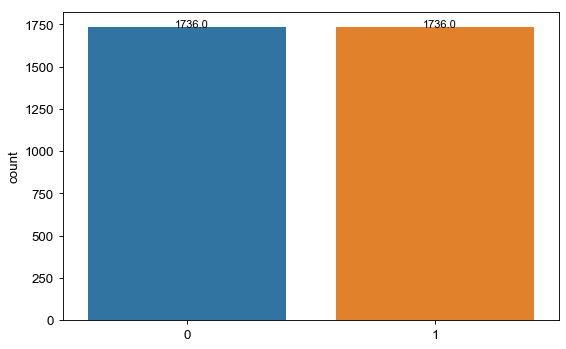

In [66]:
# 重新检查平衡程度
fig,ax = plt.subplots(figsize=(8,5), dpi=80)
sns.countplot(x=y_balance[0])
for p in ax.patches:
    ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.35, p.get_height()), color='black', size=10)
plt.show()

In [148]:
x_train_b = X_balance[0]
y_train_b = y_balance[0]
print('x_train: ', x_train_b.shape)

# Convert class vectors to binary class matrices.
num_classes = 2
y_train_b = to_categorical(y_train_b, num_classes)

# 创建模型
x_in = Input(shape=(768,))
x_out = Dense(32, activation="relu")(x_in)
x_out = BatchNormalization()(x_out)
x_out = Dense(num_classes, activation="softmax")(x_out)
model = Model(inputs=x_in, outputs=x_out)
print(model.summary())

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

# 模型训练以及评估
model.fit(x_train_b, y_train_b, batch_size=8, epochs=20)
model.save('balance_visit_classify.h5')
print(model.evaluate(x_test, y_test))

x_train:  (3472, 768)


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 768)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 32)                  │          24,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,802 (96.88 KB)

 Trainable params: 24,738 (96.63 KB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7504 - loss: 0.5154
Epoch 2/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8521 - loss: 0.3427
Epoch 3/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8844 - loss: 0.3075
Epoch 4/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8776 - loss: 0.3089
Epoch 5/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8697 - loss: 0.3011
Epoch 6/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8930 - loss: 0.2754
Epoch 7/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9048 - loss: 0.2598
Epoch 8/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8943 - loss: 0.2582
Epoch 9/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.8927 - loss: 0.2527
Epoch 10/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9048 - loss: 0.2543
Epoch 11/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9037 - loss: 0.2424
Epoch 12/20
434/434 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8371 - loss: 0.5158 
[0.5039404630661011, 0.8183831572532654]


In [149]:
#SMOTE后拟合效果
predictions = model.predict(x_test)
predictions_labels = np.argmax(predictions, axis=1)
y_test_labels = np.argmax(y_test, axis=1)
print("Accuracy score: {}".format(accuracy_score(predictions_labels, y_test_labels)))
print(classification_report(y_test_labels, predictions_labels))

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Accuracy score: 0.8183831672203765
              precision    recall  f1-score   support

           0       0.94      0.83      0.88       740
           1       0.50      0.75      0.60       163

    accuracy                           0.82       903
   macro avg       0.72      0.79      0.74       903
weighted avg       0.86      0.82      0.83       903



In [153]:
# 使用模型进行预测
predictions = model.predict(x_test)

# 将预测结果转换为类别标签
predicted_labels = np.argmax(predictions, axis=1)

# 将二进制分类矩阵转换回一维数组
y_test_labels = np.argmax(y_test, axis=1)

# 创建一个新的 DataFrame
results_df = pd.DataFrame({
    'predicted_label': predicted_labels,
    'actual_label': y_test_labels,
    'text': s_test_df['text']  # s_test_df测试文本
})

# 显示结果
print(results_df.head())

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
   predicted_label  actual_label                     text
0                0             0             三文鱼：“你说谁呢？！”
1                1             0  来，看我打开直播，给出致命一击！呀呀呀，跳劈！
2                0             0             英国皇室应该可以出面了。
3                0             0            谷歌搜索不是抄袭雅虎的吗？
4                0             0        要是忍了又没发展出来那不骂得更惨？


In [154]:
# 显示 results_df 中所有 actual_label 为 1 的行
filtered_results_df = results_df[results_df['actual_label'] == 1]

# 打印结果
filtered_results_df.head(20)

,predicted_label,actual_label,text
11,1,1,猴王还是有良心的企业家！必须点个赞！“假如小米首月供货不足百万台，大家不用催了，我就去工厂拧...
16,0,1,联想确实不属于一家中国公司，它是植根中国的买办楷模！
28,0,1,由此可以看得出来，棒子的胸怀也是美容整出来的。
32,1,1,而且你们提前一天通知，人家就是想请假也来不及吧，没有竞争的服务就是霸气！
38,1,1,我倒觉得联想没问题，人家作为一家美国良心公司，当然不是中国公司啦！
39,1,1,韩国人爱国可是有一套的，为了逃避兵役连国籍都可以放弃。
41,1,1,默克尔都连任四届了，也没见西媒叫唤。双标、假新闻岂是浪得虚名！
43,1,1,贱民也能当总统，好民主啊！
51,1,1,您这背书真厉害，嘴叭叭的就不停，声音大的我耳朵都快聋了。
54,1,1,这样一个大国，如此厚颜无耻且疑神疑鬼，必定在人类简史上留下重重一笔！


##### 模型效果检查

In [213]:
import numpy as np
from keras.utils import to_categorical
from keras.models import load_model
from transformers import AutoTokenizer

# 加载模型
model = load_model('visit_classify.h5')

# 加载tokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-chinese")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-chinese")

def encode_text(texts):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
    with torch.no_grad():
        outputs = bert_model(**inputs)
    # 使用最后一层的hidden states的平均值作为句子的表示
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    return embeddings

# 定义预测函数
def predict_text(text, model, tokenizer, bert_model):
    # 对文本进行编码
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=150)
    # 获取BERT模型的输出
    outputs = bert_model(**inputs)
    # 使用最后一层的hidden states的平均值作为句子的表示
    embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()
    # 模型预测
    predictions = model.predict(embeddings)
    # 将预测结果转换为类别标签
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class

# 输入文本
input_texts = ["这家菜不错！", 
               "这间球馆太差了！",
               "贱民也能当总统，好民主啊！",
               "哦，今天才知道，民主的洪水也泡粮食。真好笑。"]

input_embeddings = encode_text(input_texts)
x_input = np.array(input_embeddings)
pre_input = model.predict(x_input)
input_labels = np.argmax(pre_input, axis=1)
input_labels
# # 对每个文本进行预测
# for text in input_texts:
#     predicted_class = predict_text(text, model, tokenizer, bert_model)
#     print(f"文本：'{text}' 预测类别：{'讽刺' if input_labels == 0 else '非讽刺'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


array([0, 0, 1, 1], dtype=int64)

In [230]:
import numpy as np
from keras.utils import to_categorical
from keras.models import load_model
from transformers import AutoTokenizer

# 加载模型
model = load_model('balance_visit_classify.h5')

# 加载tokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-chinese")
bert_model = AutoModel.from_pretrained("google-bert/bert-base-chinese")

# 定义预测函数
def predict_text(text, model, tokenizer, bert_model):
    # 对文本进行编码
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=150)
    # 获取BERT模型的输出
    outputs = bert_model(**inputs)
    # 使用最后一层的hidden states的平均值作为句子的表示
    embeddings = outputs.last_hidden_state[:, 0, :].detach().numpy()
    # 模型预测
    predictions = model.predict(embeddings)
    # 将预测结果转换为类别标签
    predicted_class = np.argmax(predictions, axis=1)
    return predicted_class

# 输入文本
input_texts = ["真山真水拍成假山假水，这导演太厉害了。","这位李先生笑死我了。","菜品丰富，每道菜都非常美味可口。","真的太厉害了！能让大家吃的都不满意！","这个粉我知道，上次我们村闹洪灾就是这个粉把水吸完的！"]

input_embeddings = encode_text(input_texts)
x_input = np.array(input_embeddings)
pre_input = model.predict(x_input)
input_labels = np.argmax(pre_input, axis=1)
input_labels

# 对每个文本进行预测
for i, text in enumerate(input_texts):
    print(f"文本：'{text}' 预测类别：{'讽刺' if input_labels[i] == 1 else '非讽刺'}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
文本：'真山真水拍成假山假水，这导演太厉害了。' 预测类别：讽刺
文本：'这位李先生笑死我了。' 预测类别：非讽刺
文本：'菜品丰富，每道菜都非常美味可口。' 预测类别：非讽刺
文本：'真的太厉害了！能让大家吃的都不满意！' 预测类别：讽刺
文本：'这个粉我知道，上次我们村闹洪灾就是这个粉把水吸完的！' 预测类别：非讽刺


大部分文本都能判断出是否讽刺，但涉及一定语境的句子（例如上面的第五段文本），模型难以识别。后续进一步添加上下文联合识别。

### 3.3 利用模型找出原数据集的讽刺评论

In [109]:
# 重新导入Bert向量
embeddings_df = pd.read_csv("bert_emb.csv")

In [110]:
embeddings_df.head()

,problemEB_0,problemEB_1,problemEB_2,problemEB_3,problemEB_4,problemEB_5,problemEB_6,problemEB_7,problemEB_8,problemEB_9,...,problemEB_758,problemEB_759,problemEB_760,problemEB_761,problemEB_762,problemEB_763,problemEB_764,problemEB_765,problemEB_766,problemEB_767
0,0.002786,0.350907,-0.590879,0.624839,0.275236,-0.998189,0.249843,-1.160770,-0.333895,0.661828,...,-0.536378,0.239979,0.343862,0.967223,0.913974,-0.801003,-0.047445,-0.197605,0.059263,-0.138500
1,-0.388467,0.344315,0.032715,-0.823201,0.978599,-1.090205,0.495675,-0.690717,-0.325970,0.588440,...,-0.829643,-0.294156,-0.028544,-1.372434,-0.540188,-0.806019,0.476399,0.238898,-0.232822,-0.024937
2,0.239318,0.292602,0.541064,-0.180603,0.326330,-1.056555,0.003999,-1.555352,0.225033,0.333953,...,-0.635317,0.872438,0.532460,0.822976,0.994111,-1.065691,0.190030,-1.125029,0.076238,0.196769
3,0.463375,0.265843,-0.954373,-0.184800,0.771330,-1.255783,0.268276,-1.316844,-0.101130,0.470056,...,-0.718720,-0.206989,0.382353,0.192804,1.041080,-0.851206,-0.136673,-0.067548,0.217650,-0.122807
4,0.536140,0.671927,0.256286,0.845530,0.309015,-1.011913,0.090691,-0.755432,-0.736551,0.488083,...,-0.638142,0.317016,0.473254,0.544670,1.111727,-0.678114,-0.265979,-1.327919,0.226817,-0.379921


In [111]:
x_df = embeddings_df.to_numpy(dtype=np.float32)

In [112]:
x_df

array([[ 0.00278629,  0.35090706, -0.59087926, ..., -0.19760486,
         0.05926282, -0.13850011],
       [-0.38846737,  0.34431458,  0.03271492, ...,  0.23889849,
        -0.232822  , -0.02493664],
       [ 0.23931806,  0.29260227,  0.5410645 , ..., -1.125029  ,
         0.07623835,  0.19676909],
       ...,
       [ 0.55928653,  0.6094477 , -0.98230743, ..., -0.12526947,
         0.6154813 , -0.3157287 ],
       [-0.08111879,  0.8300608 , -0.02728182, ...,  0.3840966 ,
         0.05153142, -0.3311476 ],
       [ 0.7358173 ,  0.9331026 , -0.39252228, ..., -0.6822709 ,
         0.2088018 ,  0.03047774]], dtype=float32)

In [106]:
df = pd.read_csv("waimai.csv")
df

,label,review
0,1,很快，好吃，味道足，量大
1,1,没有送水没有送水没有送水
2,1,非常快，态度好。
3,1,方便，快捷，味道可口，快递给力
4,1,菜味道很棒！送餐很及时！
...,...,...
11982,0,以前几乎天天吃，现在调料什么都不放，
11983,0,昨天订凉皮两份，什么调料都没有放，就放了点麻油，特别难吃，丢了一份，再也不想吃了
11984,0,"凉皮太辣,吃不下都"
11985,0,本来迟到了还自己点！！！


In [113]:
from keras.models import load_model
# 加载模型
model = load_model('balance_visit_classify.h5')

# 使用模型进行预测
predictions = model.predict(x_df)

# 将预测结果转换为类别标签
satire_labels = np.argmax(predictions, axis=1)

# 创建一个新的 DataFrame
results_df = pd.DataFrame({
    'satire_label': satire_labels,
    'emotion_label': df['label'],
    'text': df['review'] 
})

# 显示结果
results_df

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,satire_label,emotion_label,text
0,1,1,很快，好吃，味道足，量大
1,0,1,没有送水没有送水没有送水
2,1,1,非常快，态度好。
3,0,1,方便，快捷，味道可口，快递给力
4,1,1,菜味道很棒！送餐很及时！
...,...,...,...
11982,0,0,以前几乎天天吃，现在调料什么都不放，
11983,0,0,昨天订凉皮两份，什么调料都没有放，就放了点麻油，特别难吃，丢了一份，再也不想吃了
11984,0,0,"凉皮太辣,吃不下都"
11985,1,0,本来迟到了还自己点！！！


In [246]:
# 显示 results_df 中所有 actual_label 为 1 的行
filtered_results_df = results_df[results_df['satire_label'] == 1]

# 打印结果
filtered_results_df.tail(20)

,satire_label,emotion_label,text
11932,1,0,点的超辣，结果是不辣的，而且等了一个多小时才到。真忍了。
11936,1,0,"快递小哥坚持送到位，表扬一下。,螺狮粉味道太一般。"
11938,1,0,"外卖骑士将近两小时送到,而且还要我下去取餐"
11941,1,0,送了两个多小时！大家吃饭我工作，大家开工了，我端一碗臭臭的螺狮粉，想想什么感受吧！快递大哥态...
11950,1,0,速度满，十一点四十下的单，一点半到的菜叶都是黄的，我也是醉了，送餐员满头大汗，我是心疼了
11953,1,0,下了单说一个小时之后送，过了一个小时送餐员打电话又说晚15分钟，而且态度不好！味道也一般，跟...
11955,1,0,味道没店里的好。订单少送一个绿豆沙，发票的单子的价格也是错的，懒得再打电话，送了1个小时20...
11958,1,0,粉很好吃，但是订了卤蛋却没有。
11960,1,0,粉很好吃，就是配送员找不到位置还一直埋怨，送来时已经坨了！
11961,1,0,"排骨不好吃～还都是色素～量少的可怜～58元的菜啊,只有七块排骨～一点味道没有～肉很干～坑死了..."


应该判断的是：当emotion和情感分析结果不同时，判断是否讽刺。

In [117]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# 加载模型和分词器
model = AutoModelForSequenceClassification.from_pretrained('bert_emotion_model')
utokenizer = AutoTokenizer.from_pretrained('bert_emotion_model')

# 定义预测函数
def predict(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=-1).item()
    return predicted_class

# 测试数据
test_texts = df['review'] 

# # 对测试数据进行预测
# predictions = [predict(text, model, utokenizer) for text in test_texts]
# 对测试数据进行预测
predictions = []
count = 0  # 初始化计数器
for text in test_texts:
    predictions.append(predict(text, model, utokenizer))
    count += 1  # 每次预测后增加计数器
    if count % 100 == 0:  # 每1000次预测打印一次
        print(f"预测了{count}行")

# 打印预测结果
print(predictions)  # 输出可能是 [1, 0]，具体取决于你的标签编码

预测了100行
预测了200行
预测了300行
预测了400行
预测了500行
预测了600行
预测了700行
预测了800行
预测了900行
预测了1000行
预测了1100行
预测了1200行
预测了1300行
预测了1400行
预测了1500行
预测了1600行
预测了1700行
预测了1800行
预测了1900行
预测了2000行
预测了2100行
预测了2200行
预测了2300行
预测了2400行
预测了2500行
预测了2600行
预测了2700行
预测了2800行
预测了2900行
预测了3000行
预测了3100行
预测了3200行
预测了3300行
预测了3400行
预测了3500行
预测了3600行
预测了3700行
预测了3800行
预测了3900行
预测了4000行
预测了4100行
预测了4200行
预测了4300行
预测了4400行
预测了4500行
预测了4600行
预测了4700行
预测了4800行
预测了4900行
预测了5000行
预测了5100行
预测了5200行
预测了5300行
预测了5400行
预测了5500行
预测了5600行
预测了5700行
预测了5800行
预测了5900行
预测了6000行
预测了6100行
预测了6200行
预测了6300行
预测了6400行
预测了6500行
预测了6600行
预测了6700行
预测了6800行
预测了6900行
预测了7000行
预测了7100行
预测了7200行
预测了7300行
预测了7400行
预测了7500行
预测了7600行
预测了7700行
预测了7800行
预测了7900行
预测了8000行
预测了8100行
预测了8200行
预测了8300行
预测了8400行
预测了8500行
预测了8600行
预测了8700行
预测了8800行
预测了8900行
预测了9000行
预测了9100行
预测了9200行
预测了9300行
预测了9400行
预测了9500行
预测了9600行
预测了9700行
预测了9800行
预测了9900行
预测了10000行
预测了10100行
预测了10200行
预测了10300行
预测了10400行
预测了10500行
预测了10600行
预测了10700行
预测了10800行
预测了10900行
预测了11000行
预测了11100

In [118]:
from keras.models import load_model
# 加载模型
model = load_model('balance_visit_classify.h5')

# 使用模型进行预测
satire = model.predict(x_df)

# 将预测结果转换为类别标签
satire_labels = np.argmax(satire, axis=1)

# 创建一个新的 DataFrame
results_df = pd.DataFrame({
    'satire_label': satire_labels,
    'emotion_label': df['label'],
    'predict_label': predictions,
    'text': df['review'] 
})

# 显示结果
results_df

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


,satire_label,emotion_label,predict_label,text
0,1,1,1,很快，好吃，味道足，量大
1,0,1,0,没有送水没有送水没有送水
2,1,1,1,非常快，态度好。
3,0,1,1,方便，快捷，味道可口，快递给力
4,1,1,1,菜味道很棒！送餐很及时！
...,...,...,...,...
11982,0,0,0,以前几乎天天吃，现在调料什么都不放，
11983,0,0,0,昨天订凉皮两份，什么调料都没有放，就放了点麻油，特别难吃，丢了一份，再也不想吃了
11984,0,0,0,"凉皮太辣,吃不下都"
11985,1,0,0,本来迟到了还自己点！！！


In [119]:
# 找到'predict_label'和'emotion_label'不相等的行
mismatched_rows = results_df[results_df['predict_label'] != results_df['emotion_label']]
mismatched_rows

,satire_label,emotion_label,predict_label,text
1,0,1,0,没有送水没有送水没有送水
44,1,1,0,太麻了，青笋有点小，米饭给的也不多，土豆片都碎了，找不到了
54,1,1,0,感觉没有在店里的好吃，感谢送餐师傅我们家六楼没电梯还得爬楼梯
64,0,1,0,东西还可以，但是没有在店里吃的好吃
65,0,1,0,锅底怎么是13？
...,...,...,...,...
11880,0,0,1,味道不错，送的时间长了点
11923,0,0,1,就是时间稍微长些
11960,1,0,1,粉很好吃，就是配送员找不到位置还一直埋怨，送来时已经坨了！
11969,1,0,1,谢谢！速度很快辛苦了！


In [121]:
mismatched_rows[mismatched_rows['satire_label'] == 1]

,satire_label,emotion_label,predict_label,text
44,1,1,0,太麻了，青笋有点小，米饭给的也不多，土豆片都碎了，找不到了
54,1,1,0,感觉没有在店里的好吃，感谢送餐师傅我们家六楼没电梯还得爬楼梯
136,1,1,0,"喝了好几年快乐柠檬,第一次喝曲奇奶茶,个人觉得不好喝,本人还是更喜欢茶类冰饮,给配送员赞一个..."
257,1,1,0,可惜不能更改杯型，又所有订单也不齐全
304,1,1,0,赶上雨最大的时候，外卖小哥很不容易
...,...,...,...,...
11372,1,0,1,不错，就是送的太慢了
11448,1,0,1,不错，希望品质如初！
11449,1,0,1,希望品质如一!
11960,1,0,1,粉很好吃，就是配送员找不到位置还一直埋怨，送来时已经坨了！


In [120]:
# 找到不一致的项中的讽刺项
count_satire_label_1 = mismatched_rows[mismatched_rows['satire_label'] == 1].shape[0]
print(f"判断不一致的样本中，属于讽刺样本的数量是: {count_satire_label_1}")

判断不一致的样本中，属于讽刺样本的数量是: 246


通过情绪分析和讽刺分析联合分析，找出具有争议的评论。

## 四、Stage3-订单语境+上下文分析

结合上下文，面向话题进行讽刺识别；尝试对BERT进行微调，以适应

参考文献：Topic-Oriented Sarcasm Detection: New Task, New Dataset and New Method(Bin Liang, Zijie Lin, Bing Qin, Ruifeng Xu, 2022)

### 4.1 训练模型

In [1]:
import os
import os.path as op
import argparse
import time
import json
from tqdm.notebook import tqdm
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from transformers import BatchEncoding, BertForSequenceClassification, BertTokenizer, get_cosine_schedule_with_warmup
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score

C:\Users\chennxx\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
#将原始数据（raw_data）转换成一个PyTorch的DataLoader对象
def get_dataloader(raw_data, tokenizer, batch_size=32, max_len=256, split='train', sample:int=None):
    def collate(batch):
        return {'guid': torch.stack([batch[i][0] for i in range(len(batch))], dim=0),
                'inputs': BatchEncoding({
                    'input_ids': torch.stack([batch[i][1] for i in range(len(batch))], dim=0),
                    'token_type_ids': torch.stack([batch[i][2] for i in range(len(batch))], dim=0),
                    'attention_mask': torch.stack([batch[i][3] for i in range(len(batch))], dim=0),
                }),
                'labels': torch.stack([batch[i][-1] for i in range(len(batch))], dim=0)
                }

    guids = []
    all_text = []
    labels = []
    for i, example in enumerate(raw_data):
        guids.append(i)
        text_a = example['topic']
        text_b = example['text']
        all_text.append(text_b + '[SEP]' + text_a)
        labels.append(int(example['label']))
    guids = torch.tensor(guids, dtype=torch.long)
    labels = torch.tensor(labels, dtype=torch.long)

    dataset = tokenizer(all_text[:sample] if sample else all_text,
                        max_length=max_len,
                        return_tensors='pt',
                        padding='max_length',
                        truncation=True
                        )
    dataset = TensorDataset(guids[:sample] if sample else guids,
                            dataset['input_ids'],
                            dataset['token_type_ids'],
                            dataset['attention_mask'],
                            labels[:sample] if sample else labels)

    print("%s size: %d" % (split, len(dataset)))

    if split == 'train':
        return DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=True,
            collate_fn=collate,
        )

    else:
        return DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            collate_fn=collate,
        )


In [21]:
# 模型的训练和评估
def run_msd(args, seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    device = torch.device("cpu")  # 指定设备为CPU

    model_save_path = os.path.join(args['save_path'], 'best_model.std')

    # 加载数据
    with open(op.join(args['data_path'], 'train.json'), 'r', encoding='utf-8') as f:
        train_data = json.load(f)
    with open(op.join(args['data_path'], 'dev.json'), 'r', encoding='utf-8') as f:
        valid_data = json.load(f)
    with open(op.join(args['data_path'], 'test.json'), 'r', encoding='utf-8') as f:
        test_data = json.load(f)

    tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-chinese')
    model = BertForSequenceClassification.from_pretrained('google-bert/bert-base-chinese')
    model = model.to(device)  # 将模型发送到CPU

    train_dataloader = get_dataloader(train_data, tokenizer, batch_size=args['batch_size'], max_len=args['max_length'], split='train', sample=args['num_sample'])
    valid_dataloader = get_dataloader(valid_data, tokenizer, batch_size=args['batch_size'], max_len=args['max_length'], split='valid')
    test_dataloader = get_dataloader(test_data, tokenizer, batch_size=args['batch_size'], max_len=args['max_length'], split='test')

    loss_func = nn.CrossEntropyLoss()

    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
         'weight_decay': 0.0}
    ]
    optimizer = optim.Adam(optimizer_grouped_parameters, lr=args['lr'], weight_decay=args['weight_decay'])
    total_steps = len(train_dataloader) * args['epoch']
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=0.1 * total_steps,
                                                num_training_steps=total_steps)

    # 训练
    best_f1 = 0.0
    for epoch in tqdm(range(args['epoch']), desc='Training'):
        tic = time.time()

        train_loss = 0.0
        train_size = 0
        model.train()
        optimizer.zero_grad()
        for batch in tqdm(train_dataloader, desc='Epoch: %s' % epoch):
            batch_inputs = {k: v.to(device) for k, v in batch['inputs'].items()}
            labels = batch['labels'].to(device)
            logits = model(**batch_inputs)['logits']
            loss = loss_func(logits, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            scheduler.step()

            batch_size = len(labels)
            train_loss += loss.item() * batch_size
            train_size += batch_size

        train_loss = train_loss / train_size

        # 验证
        y_pred = []
        y_true = []
        model.eval()
        with torch.no_grad():
            for batch in tqdm(valid_dataloader):
                batch_inputs = {k: v.to(device) for k, v in batch['inputs'].items()}
                labels = batch['labels']
                logits = model(**batch_inputs)['logits']
                y_pred.append(torch.argmax(logits, dim=-1).cpu().numpy())
                y_true.append(labels.cpu().numpy())

        y_pred = np.concatenate(y_pred, axis=0)
        y_true = np.concatenate(y_true, axis=0)
        results = classification_report(y_pred=y_pred, y_true=y_true)
        acc = accuracy_score(y_true, y_pred)
        p = precision_score(y_true, y_pred)
        r = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        macro_p = precision_score(y_true, y_pred, average='macro')
        macro_r = recall_score(y_true, y_pred, average='macro')
        macro_f1 = f1_score(y_true, y_pred, average='macro')

        print('-- EPOCH %s: train_loss = %.4f, time: %s s\n'
              '-- EPOCH %s: valid results: acc=%.4f, p=%.4f, r=%.4f, f1=%.4f\n'
              '--                   macro: acc=%.4f, p=%.4f, r=%.4f, f1=%.4f' % (
                  epoch, train_loss, time.time() - tic, epoch, acc, p, r, f1, acc, macro_p, macro_r, macro_f1))
        print(results)
        if best_f1 < f1:
            best_f1 = f1
            print('-- EPOCH %s: new best model! save to %s' % (epoch, model_save_path))
            torch.save(model.state_dict(), model_save_path)

    # 测试
    model.load_state_dict(torch.load(model_save_path))

    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for batch in tqdm(test_dataloader):
            batch_inputs = {k: v.to(device) for k, v in batch['inputs'].items()}
            labels = batch['labels']
            logits = model(**batch_inputs)['logits']
            y_pred.append(torch.argmax(logits, dim=-1).cpu().numpy())
            y_true.append(labels.cpu().numpy())

    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    results = classification_report(y_pred=y_pred, y_true=y_true)
    acc = accuracy_score(y_true, y_pred)
    p = precision_score(y_true, y_pred)
    r = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    macro_p = precision_score(y_true, y_pred, average='macro')
    macro_r = recall_score(y_true, y_pred, average='macro')
    macro_f1 = f1_score(y_true, y_pred, average='macro')

    print('-- test results: acc=%.4f, p=%.4f, r=%.4f, f1=%.4f\n'
          '--        macro: acc=%.4f, p=%.4f, r=%.4f, f1=%.4f' % (acc, p, r, f1, acc, macro_p, macro_r, macro_f1))
    print(results)

    return {'accuracy': acc,
            'precision': p,
            'recall': r,
            'f1': f1,
            'macro precision': macro_p,
            'macro recall': macro_r,
            'macro f1': macro_f1}

In [23]:
# 模型参数
args = {
    'epoch': 6,
    'batch_size': 32,
    'max_length': 256,
    'lr': 2e-5,
    'weight_decay': 2e-3,
    'num_sample': None,
    'seed': 42,
    'seeds': [1001, 1002, 1003, 1004, 1005],
    'gpu_id': 0,
    'data_path': './12-topic/data/',
    'save_path': './12-topic/save/bert/'
}

# 运行模型
results = run_msd(args, seed=42)
print(results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


train size: 2925
valid size: 973
test size: 973


Training:   0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 0:   0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

-- EPOCH 0: train_loss = 0.6912, time: 3868.4555852413177 s
-- EPOCH 0: valid results: acc=0.6341, p=0.7605, r=0.6932, f1=0.7253
--                   macro: acc=0.6341, p=0.5873, r=0.5958, f1=0.5888
              precision    recall  f1-score   support

           0       0.41      0.50      0.45       295
           1       0.76      0.69      0.73       678

    accuracy                           0.63       973
   macro avg       0.59      0.60      0.59       973
weighted avg       0.66      0.63      0.64       973

-- EPOCH 0: new best model! save to ./12-topic/save/bert/best_model.std


Epoch: 1:   0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

-- EPOCH 1: train_loss = 0.6089, time: 3695.739688396454 s
-- EPOCH 1: valid results: acc=0.6927, p=0.8427, r=0.6873, f1=0.7571
--                   macro: acc=0.6927, p=0.6690, r=0.6962, f1=0.6695
              precision    recall  f1-score   support

           0       0.50      0.71      0.58       295
           1       0.84      0.69      0.76       678

    accuracy                           0.69       973
   macro avg       0.67      0.70      0.67       973
weighted avg       0.74      0.69      0.70       973

-- EPOCH 1: new best model! save to ./12-topic/save/bert/best_model.std


Epoch: 2:   0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

-- EPOCH 2: train_loss = 0.4775, time: 3671.495871782303 s
-- EPOCH 2: valid results: acc=0.6937, p=0.8506, r=0.6799, f1=0.7557
--                   macro: acc=0.6937, p=0.6735, r=0.7027, f1=0.6726
              precision    recall  f1-score   support

           0       0.50      0.73      0.59       295
           1       0.85      0.68      0.76       678

    accuracy                           0.69       973
   macro avg       0.67      0.70      0.67       973
weighted avg       0.74      0.69      0.71       973



Epoch: 3:   0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

-- EPOCH 3: train_loss = 0.3210, time: 3669.560477733612 s
-- EPOCH 3: valid results: acc=0.7040, p=0.8272, r=0.7271, f1=0.7739
--                   macro: acc=0.7040, p=0.6682, r=0.6890, f1=0.6727
              precision    recall  f1-score   support

           0       0.51      0.65      0.57       295
           1       0.83      0.73      0.77       678

    accuracy                           0.70       973
   macro avg       0.67      0.69      0.67       973
weighted avg       0.73      0.70      0.71       973

-- EPOCH 3: new best model! save to ./12-topic/save/bert/best_model.std


Epoch: 4:   0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

-- EPOCH 4: train_loss = 0.2066, time: 3674.1471524238586 s
-- EPOCH 4: valid results: acc=0.7040, p=0.8533, r=0.6947, f1=0.7659
--                   macro: acc=0.7040, p=0.6808, r=0.7101, f1=0.6818
              precision    recall  f1-score   support

           0       0.51      0.73      0.60       295
           1       0.85      0.69      0.77       678

    accuracy                           0.70       973
   macro avg       0.68      0.71      0.68       973
weighted avg       0.75      0.70      0.71       973



Epoch: 5:   0%|          | 0/92 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

-- EPOCH 5: train_loss = 0.1459, time: 3671.5300636291504 s
-- EPOCH 5: valid results: acc=0.6999, p=0.8362, r=0.7080, f1=0.7668
--                   macro: acc=0.6999, p=0.6700, r=0.6947, f1=0.6730
              precision    recall  f1-score   support

           0       0.50      0.68      0.58       295
           1       0.84      0.71      0.77       678

    accuracy                           0.70       973
   macro avg       0.67      0.69      0.67       973
weighted avg       0.74      0.70      0.71       973



  0%|          | 0/31 [00:00<?, ?it/s]

-- test results: acc=0.6948, p=0.7753, r=0.7368, f1=0.7556
--        macro: acc=0.6948, p=0.6724, r=0.6784, f1=0.6746
              precision    recall  f1-score   support

           0       0.57      0.62      0.59       350
           1       0.78      0.74      0.76       623

    accuracy                           0.69       973
   macro avg       0.67      0.68      0.67       973
weighted avg       0.70      0.69      0.70       973

{'accuracy': 0.6947584789311408, 'precision': 0.7753378378378378, 'recall': 0.7367576243980738, 'f1': 0.7555555555555555, 'macro precision': 0.672445821806058, 'macro recall': 0.6783788121990368, 'macro f1': 0.6746314029487763}


### 4.2 测试模型

In [110]:
import torch
from transformers import BertForSequenceClassification, BertTokenizer

# 指定模型保存的路径
model_path = './12-topic/save/bert/best_model.std'

# 加载模型
model = BertForSequenceClassification.from_pretrained('google-bert/bert-base-chinese')
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
model.eval()  # 设置为评估模式

# 加载分词器
tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-chinese')

# 定义一个函数来进行预测
def predict(text_a, text_b):
    # 将文本组合成一个字符串，因为训练时是将text_b和text_a拼接在一起的
    input_text = text_b + '[SEP]' + text_a

    # 使用分词器对输入文本进行编码
    inputs = tokenizer.encode_plus(
        input_text,
        add_special_tokens=True,
        return_token_type_ids=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # 获取输入ID和注意力掩码
    input_ids = inputs['input_ids'].tolist()[0]
    attention_mask = inputs['attention_mask'].tolist()[0]

    # 将输入数据转换为模型需要的格式
    inputs = {
        'input_ids': torch.tensor([input_ids]),
        'attention_mask': torch.tensor([attention_mask])
    }

    # 进行预测
    with torch.no_grad():
        outputs = model(**inputs)
    
    # 获取预测结果
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).item()

    # 根据预测结果返回相应的文本
    return "是" if predictions == 1 else "不是"

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [114]:
# 使用模型进行预测
text_a = "顾客在外卖平台上购买商品。"
text_b = "这个粉我知道，上次我们村闹洪灾就是这个粉把水吸完的！"
prediction = predict(text_a, text_b)
print(f"“{text_b}”【{prediction}】对“{text_a}”【的讽刺】")

“这个粉我知道，上次我们村闹洪灾就是这个粉把水吸完的！”【是】对“顾客在外卖平台上购买商品。”【的讽刺】


In [115]:
# 使用模型进行预测
text_a = "顾客在外卖平台上购买商品。"
text_b = "菜做的不好吃"
prediction = predict(text_a, text_b)
print(f"“{text_b}”【{prediction}】对“{text_a}”【的讽刺】")

“菜做的不好吃”【不是】对“顾客在外卖平台上购买商品。”【的讽刺】


能够对相应的上下文文本做出讽刺检验，对上述讽刺检验做了良好的补充。